In [11]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

import torchvision

LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCH = 10

In [12]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)) 
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.fc1 = torch.nn.Linear(in_features= 16 * 5 * 5, out_features=120)
        self.act1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(in_features=120, out_features=84)
        self.act2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return torch.nn.functional.softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
def train(net, train_loader, loss_function, optimizer):
    net.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        y_pred = net(X_batch)
        loss_value = loss_function(y_pred, y_batch)
        loss_value.backward()
        optimizer.step()

In [14]:
def test(net, test_loader):
    correct = 0
    
    net.eval()
    with torch.no_grad():
        for X_batch, y_patch in test_loader:
            y_pred = net(X_batch)
            
            pred = y_pred.data.max(1, keepdim=True)[1]
            
            correct += pred.eq(y_patch.data.view_as(pred)).sum()
            
    return correct / len(test_loader.dataset)

In [15]:
def show_images(pred_info, X_test, y_test, mapping):
    from collections import defaultdict
    import matplotlib.pyplot as plt

    image_prob_dict = {}
    image_dict = {}

    for idx, el_info in enumerate(pred_info):
        true_class = y_test[idx]

        image = X_test[idx].squeeze(dim=0).numpy()

        if true_class not in image_prob_dict:
            image_prob_dict[true_class] = {}
            image_dict[true_class] = {}

        for idx_j, pred_value in enumerate(el_info):
            if idx_j not in image_prob_dict[true_class]:
                image_prob_dict[true_class][idx_j] = 0
                image_dict[true_class][idx_j] = []

            if pred_value >= image_prob_dict[true_class][idx_j]:
                image_prob_dict[true_class][idx_j] = pred_value
                image_dict[true_class][idx_j] = image
                
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(16, 10), sharex=True, sharey=True)

    count = len(mapping)
    
    for i in range(count):
        for j in range(count):
            if i in image_dict and j in image_dict[i]:
                ax[i, j].imshow(image_dict[i][j])

In [16]:
def print_confusion_matrix_and_show_images(test_data, net, mapping, accuracy):
    
    from sklearn.metrics import confusion_matrix
    
    X_test = test_data.data
    X_test = torch.unsqueeze(X_test, dim=1)

    y_test = test_data.targets

    y_pred = net(X_test.float())

    pred_info = y_pred.detach().numpy()

    pred = y_pred.data.max(1, keepdim=True)[1]

    pred = pred.squeeze_(dim=1).numpy()
    y_test = y_test.numpy()

    cf = confusion_matrix(y_test, pred)
    display = ConfusionMatrixDisplay(cf, display_labels = list(mapping.values()))
    fig = plt.figure(figsize=(14, 9))
    display.plot(ax=fig.add_subplot(111), values_format="d")
    plt.show()
    print("Accuracy: " + "{0:.5f}".format(accuracy))
    
    show_images(pred_info, X_test, y_test, mapping)

In [17]:
def run(train_loader, test_loader, test_data, mapping, title, epochs_number = EPOCH):
    net = CNN()
    
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    
    epochs = []
    values = []
    for epoch in tqdm(range(epochs_number)):
        train(net, train_loader, loss_function, optimizer)
        epoch_res = test(net, test_loader)
        epochs.append(epoch + 1)
        values.append(epoch_res.item())

    plt.figure(figsize=(16, 9))
    plt.grid(linestyle='--')
    plt.xticks(epochs)
    plt.plot(epochs, values, linestyle='-',marker='.',color='r')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()    
        
    print_confusion_matrix_and_show_images(test_data, net, mapping, epoch_res.item())

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-12-1534ea861f46>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(x)
100%|██████████| 10/10 [02:33<00:00, 15.38s/it]


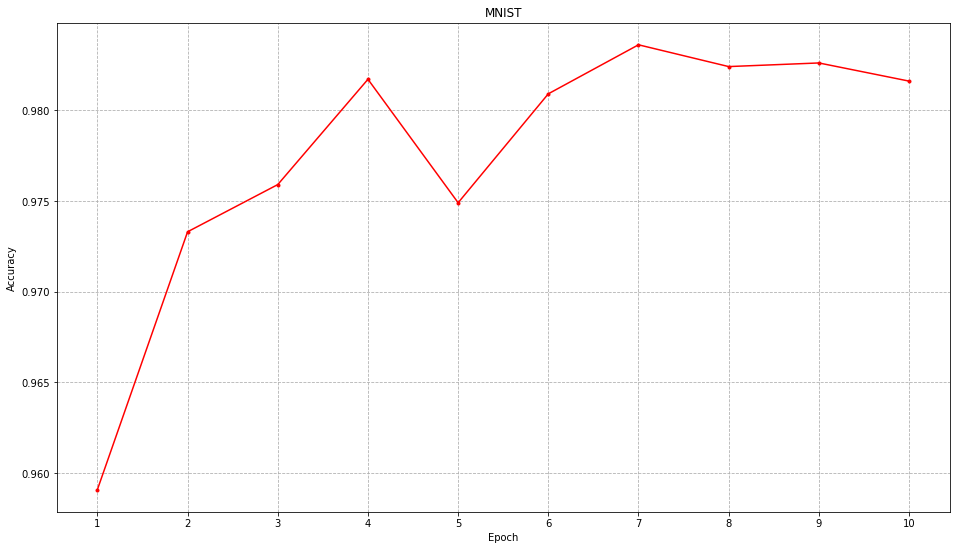

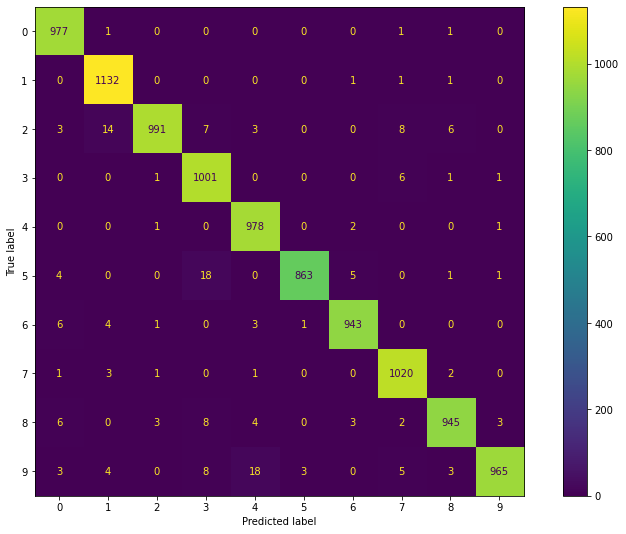

Accuracy: 0.98160


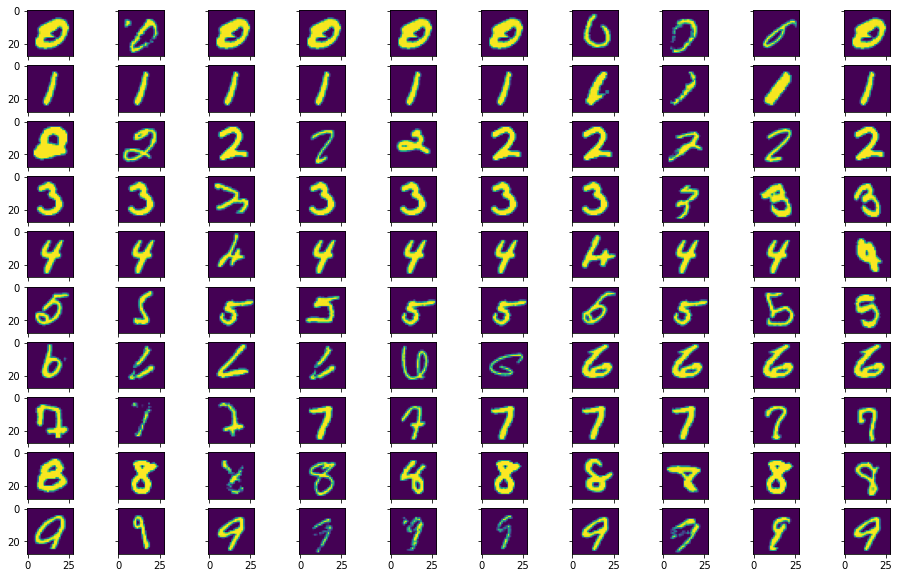

In [18]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_data = torchvision.datasets.MNIST('./', train=False, download=True)

digits_mapping = dict([(i, str(i)) for i in range(10)])

run(train_loader, test_loader, test_data, digits_mapping, "MNIST")

  0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-12-1534ea861f46>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(x)
100%|██████████| 40/40 [12:40<00:00, 19.01s/it]


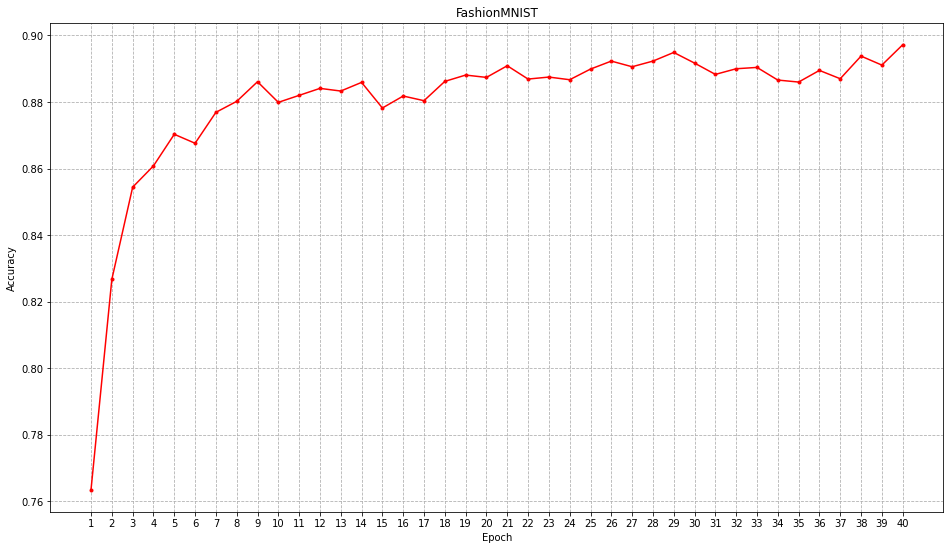

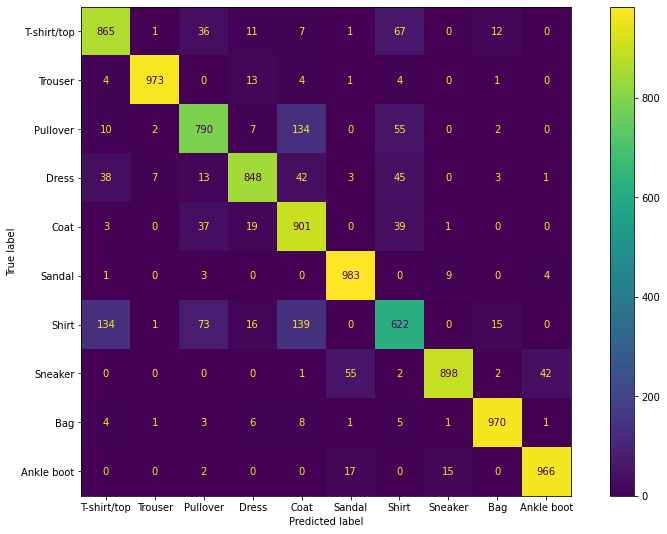

Accuracy: 0.89720


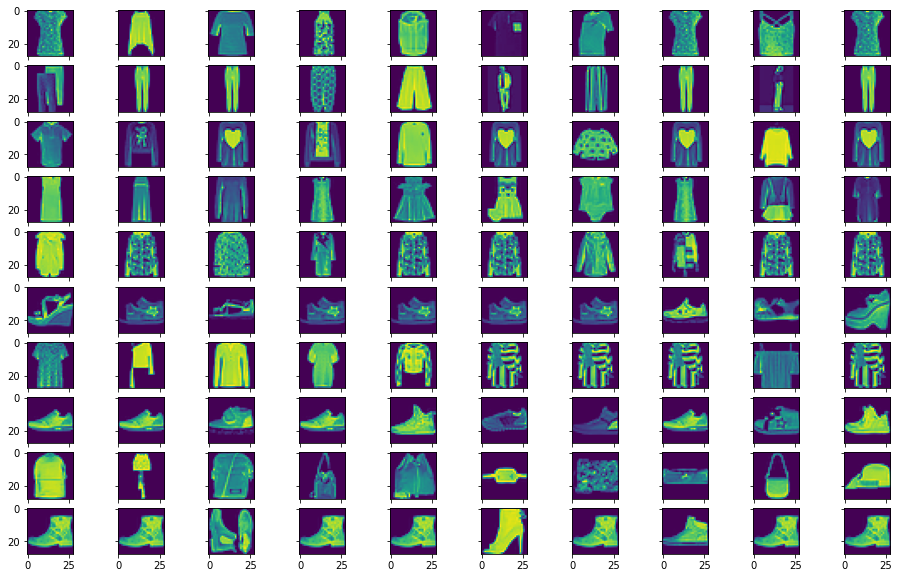

In [19]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_data = torchvision.datasets.FashionMNIST('./', train=False, download=True)

fashion_mappings = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

run(train_loader, test_loader, test_data, fashion_mappings, "FashionMNIST", EPOCH * 4)